# Physics Informed Neural Networks Review: Applications in Option pricing

## Understanding Physics-Informed Neural Networks (PINNs)

**Sources**

1. [Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations](https://arxiv.org/abs/1711.10561)
2. [Introduction to Physics-informed Neural Networks](https://towardsdatascience.com/solving-differential-equations-with-neural-networks-afdcf7b8bcc4)
3. [Physics Informed Neural Networks](https://github.com/maziarraissi/PINNs)
4. [Solving multidimensional PDEs in pytorch](https://jparkhill.netlify.app/solvingdiffusions/)
5. [Black Scholes Pricing and Hedging](https://personal.ntu.edu.sg/nprivault/MA5182/black-scholes-pde.pdf)
6. [Black-Scholes Implementation in Python](https://www.youtube.com/watch?v=FzeXWMlTDHY&ab_channel=QuantPy)
7. [Black-Scholes PDE Derivation](https://www.youtube.com/watch?v=6LhV32OIZ1Y&list=PLqpCwow11-Oq9xz_ptjN5FOKTHCL9F8LH&ab_channel=QuantPy)
8. [What are Options?](https://www.investopedia.com/terms/o/option.asp)
9. [Limitations of Black Scholes](https://www.investopedia.com/articles/active-trading/041015/how-circumvent-limitations-blackscholes-model.asp)

***What are PINNs?***
- Deep learning models that combine Neural Networks with physical laws.
- Incorporate domain specific knowledge like governing equations and boundary conditions into the training process.

***How do PINNs work?***
- Loss Function: In addition to the standard loss function used in neural network training (such as mean squared error), a PINN includes terms that enforce the underlying physics. These terms are derived from the governing equations and are used to regularize the function.

- Training: During training, the neural network aims to minimize the combined loss from both the data and the physics constraints. This encourages the network to learn not only from the data but also to satisfy the physics equations.

***Why PINNs?***
- Data Efficiency: PINNs can learn from sparse data and still provide accurate solutions by leveraging the physical knowledge encoded in the loss function.

- Flexibility: They can handle complex geometries, irregular data distributions, and missing data, which can be challenging for traditional numerical methods.

- Generalization: Once trained, PINNs can generalize well to new scenarios or parameter values within the same problem domain.

### Imports

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model_networks import DNN
from pinn import PhysicsInformedNN
from black_scholes_util import black_scholes_call, black_scholes_put
import warnings
warnings.filterwarnings('ignore')
device = torch.device("mps")

## Training PINNs to predict option prices using Black Scholes PDE and synthetic data

In [2]:
S_min = torch.tensor(126)
S_max = torch.tensor(182)
T_min = torch.tensor(0.002)
T_max = torch.tensor(2.3)
K = torch.tensor(160)
r = torch.tensor(0.05)
sigma = torch.tensor(0.2)
num_samples = 100

S_samples = torch.linspace(S_min, S_max, num_samples)
t_samples = torch.linspace(T_min, T_max, num_samples)
s_grid, t_grid = torch.meshgrid(S_samples, t_samples)
X_train = torch.stack([s_grid.flatten(), t_grid.flatten()], dim=1)
X_train.requires_grad = True

call_price = black_scholes_call(s_grid.flatten(), K, t_grid.flatten(), r, sigma)
put_price = black_scholes_put(s_grid.flatten(), K, t_grid.flatten(), r, sigma)

print("Call Price:", call_price[-1])
print("Put Price:", put_price[0])

Call Price: tensor(45.1759)
Put Price: tensor(33.9840)


In [3]:
layers = [2] + list(reversed([2**x for x in range(2,11)])) + [1]
network = DNN(layers)
device = torch.device("mps")

model_vanilla = PhysicsInformedNN(s=s_grid.flatten().unsqueeze(1), t=t_grid.flatten().unsqueeze(1),u=call_price,network=network,device=device)

model_vanilla.train()

It: 0, Loss: 3.91183e+02
It: 100, Loss: 1.22841e+02
It: 200, Loss: 1.22784e+02
It: 300, Loss: 1.22706e+02
It: 400, Loss: 1.22583e+02
It: 500, Loss: 1.22410e+02
It: 600, Loss: 1.22218e+02
It: 700, Loss: 1.22205e+02
It: 800, Loss: 1.21965e+02
It: 900, Loss: 1.22101e+02
It: 1000, Loss: 1.22257e+02
It: 1100, Loss: 1.21993e+02
It: 1200, Loss: 1.21060e+02
It: 1300, Loss: 1.27189e+02
It: 1400, Loss: 1.21050e+02
It: 1500, Loss: 1.20413e+02
It: 1600, Loss: 1.20241e+02
It: 1700, Loss: 1.20189e+02
It: 1800, Loss: 1.20159e+02
It: 1900, Loss: 1.20157e+02
It: 2000, Loss: 1.20155e+02
It: 2100, Loss: 1.20157e+02


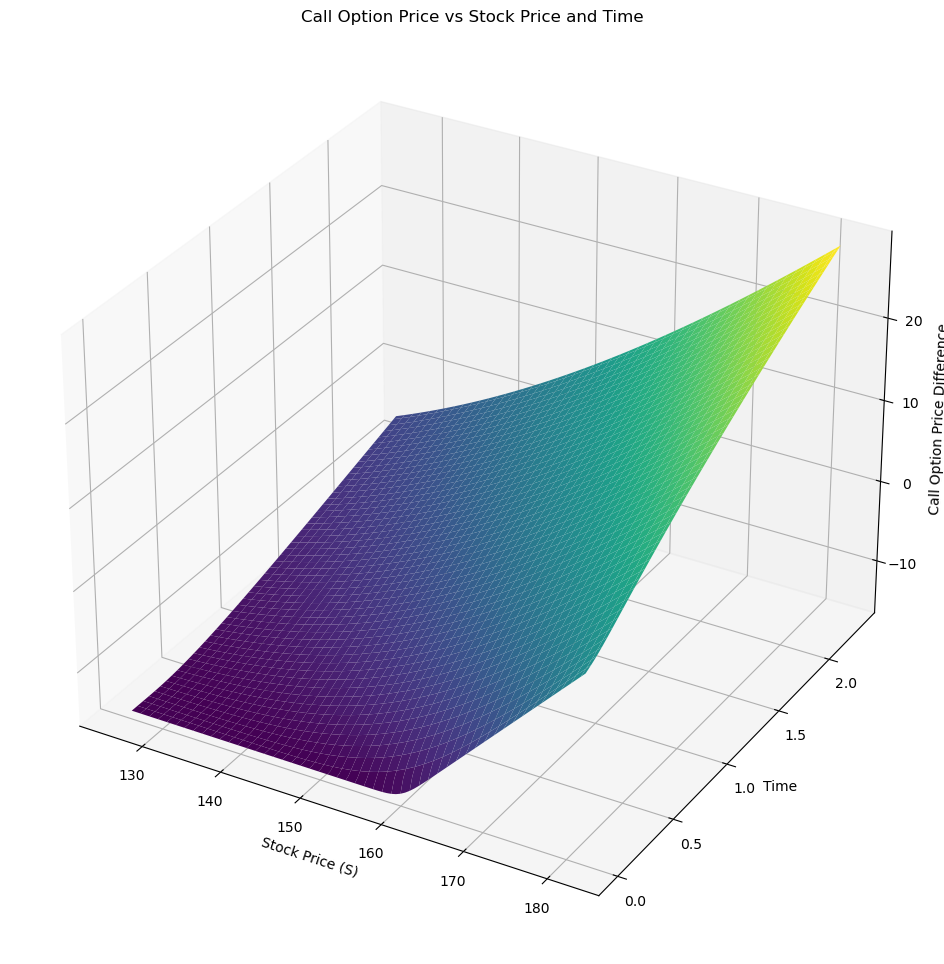

In [4]:
S_plot = torch.linspace(S_min, S_max, num_samples)
t_plot = torch.linspace(T_min, T_max, num_samples)
S_plot_grid, t_plot_grid = torch.meshgrid(S_plot, t_plot)
X_plot = torch.stack([S_plot_grid.flatten(), t_plot_grid.flatten()], axis=1)

u, f = model_vanilla.predict(S_plot.flatten().unsqueeze(1), t_plot.flatten().unsqueeze(1))
call_price = black_scholes_call(S_plot_grid, K, t_plot_grid, r, sigma).detach().numpy()
diff = call_price - u

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(S_plot_grid, t_plot_grid, diff, cmap='viridis')

ax.set_xlabel('Stock Price (S)')
ax.set_ylabel('Time')
ax.set_zlabel('Call Option Price Difference')
ax.set_title('Call Option Price vs Stock Price and Time')
plt.show()

## Training PINNs to predict option prices using Black Scholes PDE and DeepXDE


In [5]:
import deepxde as dde

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [6]:
geom = dde.geometry.Interval(S_min, S_max)
timedomain = dde.geometry.TimeDomain(T_min, T_max)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [7]:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + (0.5 * (sigma.item() ** 2) * (x[:,0] ** 2) * dy_xx) + (r.item() * x[:,0] * dy_x) - (r.item() * y)

In [8]:
# Initial and boundary conditions:
bc = dde.icbc.DirichletBC(geomtime, lambda x: dirichlet_boundary_condition(x), lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: max(x - 160, 0),
    lambda _, on_initial: on_initial,
)

def dirichlet_boundary_condition(x):
    if x <= 0:
        return 0  # Option value is zero when the asset price is zero
    return max(x - 160, 0)  # Option value at maturity


In [9]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [],
    num_domain=2540,
    num_test=2540,
)

In [10]:
net = dde.nn.FNN([2] + [100] * 3 + [1], "tanh", "Glorot normal")
model_dde = dde.Model(data, net)

# Build and train the model:
model_dde.compile("adam", lr=1e-3)
model_dde.train(iterations=20000)
model_dde.compile("L-BFGS")
losshistory, train_state = model_dde.train()

Compiling model...
'compile' took 0.000445 s
Training model...

Step      Train loss    Test loss     Test metric
0         [5.97e-03]    [5.95e-03]    []  
1000      [5.41e-09]    [5.34e-09]    []  
2000      [3.77e-10]    [3.85e-10]    []  
3000      [1.68e-10]    [1.66e-10]    []  
4000      [1.25e-10]    [1.27e-10]    []  
5000      [5.12e-11]    [5.01e-11]    []  
6000      [9.43e-06]    [9.42e-06]    []  
7000      [2.76e-11]    [2.63e-11]    []  
8000      [8.26e-11]    [7.65e-11]    []  
9000      [2.40e-11]    [2.21e-11]    []  
10000     [7.47e-12]    [7.00e-12]    []  
11000     [3.07e-12]    [2.97e-12]    []  
12000     [4.04e-11]    [4.33e-11]    []  
13000     [5.38e-12]    [5.91e-12]    []  
14000     [9.40e-13]    [1.01e-12]    []  
15000     [2.70e-12]    [2.82e-12]    []  
16000     [5.92e-09]    [5.95e-09]    []  
17000     [9.23e-14]    [8.00e-14]    []  
18000     [3.65e-12]    [3.65e-12]    []  
19000     [1.68e-14]    [1.67e-14]    []  
20000     [1.54e-14]    [1

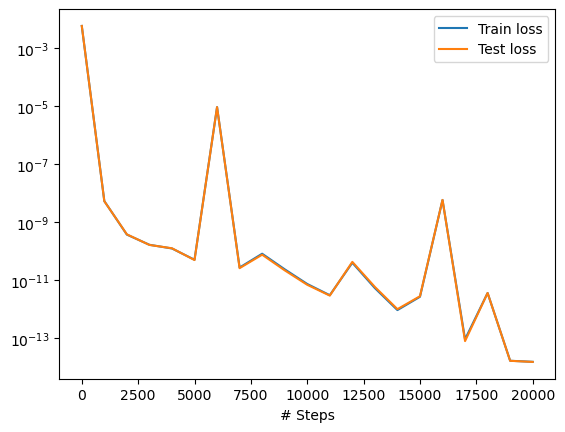

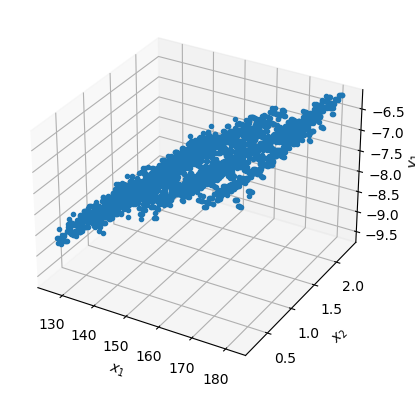

In [11]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

## Training Black-Scholes on AAPL options data from 2022

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model_networks import DNN
from pinn import PhysicsInformedNN
from black_scholes_util import black_scholes_call, black_scholes_put
import warnings
warnings.filterwarnings('ignore')
device = torch.device("mps")
from data_processing import process_options_data
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from model_networks import NCLNetwork
from pinn import PINNWithDataLoader


In [2]:
torch.mps.empty_cache()

In [3]:
options_data = pd.read_csv("data/option_prices_aapl_2022.csv")
stocks_data = pd.read_csv("data/stock_prices_aapl_2022.csv")

In [4]:
call_options_data = process_options_data(options_data,stocks_data)

In [5]:
call_options_data.head()

,index,last_date,strike_price,best_bid,best_offer,impl_volatility,contract_size,Close,time_to_expiration
0,18,2022-01-03,152500,28.25,31.25,0.937468,100,182.01,0.010959
1,20,2022-01-03,157500,24.20,24.95,0.630916,100,182.01,0.010959
2,22,2022-01-03,162500,19.30,20.65,0.753108,100,182.01,0.010959
3,26,2022-01-03,172500,9.40,9.65,0.196803,100,182.01,0.010959
4,27,2022-01-03,175000,7.10,7.20,0.247537,100,182.01,0.010959


Definition of the data:

1. [Strike Price](https://www.investopedia.com/terms/s/strikeprice.asp)
2. [Implied Volatility](https://www.investopedia.com/terms/i/iv.asp)
3. [Options Greeks](https://www.investopedia.com/trading/getting-to-know-the-greeks/#toc-delta)
4. [Forward Price](https://www.investopedia.com/terms/f/forwardprice.asp)

In [15]:
train_call_options_data, test_call_options_data = train_test_split(call_options_data, test_size=0.9)

In [16]:
train_call_options_data = train_call_options_data.reset_index(drop=True)
test_call_options_data = test_call_options_data.reset_index(drop=True)

In [17]:
train_call_options_data.describe()

,index,strike_price,best_bid,best_offer,impl_volatility,contract_size,Close,time_to_expiration
count,20150.000000,20150.000000,20150.000000,20150.000000,20150.000000,20150.0,20150.000000,20150.000000
mean,115933.324169,164648.722084,24.399219,24.774468,0.451950,100.0,154.313455,0.562396
std,67321.691828,62447.767297,30.800441,31.106313,0.281257,0.0,13.011668,0.595627
min,42.000000,28750.000000,0.000000,0.010000,0.174370,100.0,126.040000,0.002740
25%,57604.250000,120000.000000,0.420000,0.490000,0.310206,100.0,143.860000,0.082192
50%,115363.000000,160000.000000,9.750000,10.100000,0.367157,100.0,153.040000,0.356164
75%,174614.250000,210000.000000,40.450000,41.000000,0.475971,100.0,165.380000,0.846575
max,231744.000000,320000.000000,144.700000,146.150000,2.998775,100.0,182.010000,2.350685


### Converting Data to Tensor and Data Loader

In [18]:
X_train = torch.tensor(train_call_options_data[['Close','time_to_expiration']].values, dtype=torch.float32)
y_train = torch.tensor(train_call_options_data.best_bid.values, dtype=torch.float32)

X_test = torch.tensor(test_call_options_data[['Close','time_to_expiration']].values, dtype=torch.float32)
y_test = torch.tensor(test_call_options_data.best_bid.values, dtype=torch.float32)

In [19]:
batch_size = 64

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [20]:
#Model Parameters
input_size = 2
output_size = 1
num_blocks = 10
hidden_size = 64
num_layers = 3
dropout_prob = 0.5

network_aapl = NCLNetwork(input_size, output_size, num_blocks, hidden_size, num_layers, dropout_prob)

model_aapl = PhysicsInformedNN(X_train[:, 0].unsqueeze(1), X_train[:, 1].unsqueeze(1), y_train, network_aapl, device)

In [21]:
X_train.shape

torch.Size([20150, 2])

In [22]:
model_aapl.train()

It: 0, Loss: 1.54710e+03
It: 100, Loss: 1.46605e+03
It: 200, Loss: 1.28440e+03
It: 300, Loss: 1.10163e+03
It: 400, Loss: 9.99258e+02
It: 500, Loss: 9.70289e+02
It: 600, Loss: 9.63950e+02
It: 700, Loss: 9.61111e+02
It: 800, Loss: 9.59465e+02
It: 900, Loss: 9.58689e+02
It: 1000, Loss: 9.58053e+02
It: 1100, Loss: 9.57793e+02
It: 1200, Loss: 9.57651e+02
It: 1300, Loss: 9.57815e+02
It: 1400, Loss: 9.57586e+02
It: 1500, Loss: 9.57485e+02
It: 1600, Loss: 9.57416e+02
It: 1700, Loss: 9.57642e+02
It: 1800, Loss: 9.57458e+02
It: 1900, Loss: 9.57497e+02
It: 2000, Loss: 9.57441e+02
It: 2100, Loss: 9.57329e+02
It: 2200, Loss: 9.57469e+02
It: 2300, Loss: 9.57471e+02
It: 2400, Loss: 9.57463e+02
It: 2500, Loss: 9.57503e+02
It: 2600, Loss: 9.57401e+02
It: 2700, Loss: 9.57509e+02
It: 2800, Loss: 9.57513e+02
It: 2900, Loss: 9.57380e+02
It: 3000, Loss: 9.57274e+02
It: 3100, Loss: 9.57454e+02
It: 3200, Loss: 9.57341e+02
It: 3300, Loss: 9.57356e+02
It: 3400, Loss: 9.57304e+02
It: 3500, Loss: 9.57320e+02
It: 